In [25]:
from userModel import User
import pandas as pd
import numpy as np
from tqdm import tqdm
import pandas as pd

import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt

from agentDev import markovianAgent,lastAgent,get_report,shortcut_track,randomAgent

In [26]:
def generate(agent) :
    Shortcuts = []
    Actions = []
    commands = []
    finish = False 
    i = 0
    command,shortcut = 0,True
    adversity = np.random.uniform(0,1)
    log = np.random.uniform(-5,-1)
    init_forget = 10**(log)
    cumul_forget = np.random.uniform(0.2,0.7)
    interrupt = np.random.uniform(0,1)
    adam =  User(adversity,init_forget,cumul_forget,interrupt,"z")
    while (i<30) : 
            action = agent.get_action(command,shortcut)
            reward, next_command,shortcut ,done = adam.interact(action)
            Actions.append(action)
            commands.append(next_command)
            Shortcuts.append(shortcut*1)
            i +=1
    data = np.array([Shortcuts,Actions,commands]).astype(np.float64)
    return data,adam.init_forget

In [27]:
adam = User(0.6,0.01,0.5,0.3,"z")

In [28]:
agent = randomAgent(12)

In [29]:
data , adv = generate(agent)

In [30]:
data.shape

(3, 30)

In [31]:
X = []
y = []
from tqdm import tqdm
for i in tqdm(range(100)) :
    data,adv = generate(agent)
    X.append(data)
    y.append(adv)

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 36.25it/s]


In [34]:
for i in range(len(X)) : 
    X[i] = X[i].T.reshape(1,30,3)

In [35]:
import pandas as pd 
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader,Dataset

In [38]:
class CNN(nn.Module) : 
    def __init__(self, in_channels =1):
        super(CNN,self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=8,kernel_size = (3,3),stride=(1,1),padding=(1,1))
        self.conv15 = nn.Conv2d(in_channels=8, out_channels=8,kernel_size = (3,3),stride=(1,1),padding=(1,1))
        self.pool = nn.MaxPool2d(kernel_size = (2,2),stride=(1,1))
        self.conv2 = nn.Conv2d(in_channels=8, out_channels=16,kernel_size = (3,3),stride=(1,1),padding=(1,1))
        self.fc1 = nn.Linear(448,20)
        self.fc2 = nn.Linear(20,1)
    def forward(self,x) : 
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv15(x))
        x = self.pool(x)
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = x.reshape(x.shape[0],-1)
        x = self.fc1(x)
        x = self.fc2(x)
        
        return x

In [39]:
model = CNN()
model(torch.tensor([X[0]],dtype=torch.float32))

tensor([[0.1149]], grad_fn=<AddmmBackward0>)

In [40]:
class UserDataset(Dataset) :
    def __init__(self,X,y) : 
        self.data = X
        self.label = y
    
    def __len__(self) : 
        return len(self.data)
    
    def __getitem__(self , index) : 
        return (torch.tensor(self.data[index],dtype=torch.float32) ,
                torch.tensor(self.label[index],dtype=torch.float32))

In [17]:
train_dataset = UserDataset(X[:7000],y[:7000])
test_dataset = UserDataset(X[7000:],y[7000:])
train_loader = DataLoader(dataset = train_dataset,
                          batch_size= 64)
test_loader = DataLoader(dataset = test_dataset,
                          batch_size= 64)

In [18]:
def checkit(loader,model) :
    mse = 0
    samples = 0
    with torch.no_grad() :
        for x,y in loader :
            scores = model(x)
            mse += criterion(scores,y)*scores.size(0)
            samples += scores.size(0)
        mss = mse/samples
        print(mss)

In [22]:
model = CNN()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(),lr=0.0001)

for epoch in range(51) :
    for idx, (data,targets) in enumerate(train_loader) :
        scores = model(data)
        loss = criterion(scores,targets)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    if epoch % 10 == 0 :
        print(f"train")
        checkit(train_loader,model)
        print(f"test")
        checkit(test_loader,model)
        print('###############')

train
tensor(0.0009)
test
tensor(0.0009)
###############
train
tensor(0.0005)
test
tensor(0.0005)
###############
train
tensor(0.0004)
test
tensor(0.0005)
###############
train
tensor(0.0004)
test
tensor(0.0005)
###############
train
tensor(0.0004)
test
tensor(0.0005)
###############
train
tensor(0.0004)
test
tensor(0.0005)
###############


In [23]:
pred = []
true = []
for i in range(3000) :
    pred.append(model(torch.tensor([X[i + 7000]],dtype=torch.float32)).detach().numpy().flatten())
    true.append(y[i + 7000])
    
# pred = np.log(pred)/np.log(10)
# true = np.log(true)/np.log(10)
# pred = np.nan_to_num(pred,nan=-5)
# true = np.nan_to_num(true,nan=-5)
from sklearn.metrics import mean_squared_error,mean_absolute_error
mean_absolute_error(pred,true)

0.013979118029935707

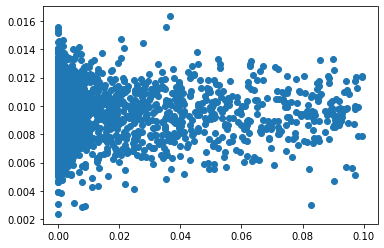

In [24]:
import matplotlib.pyplot as plt
plt.scatter(true,pred)